# `lsdtopytools` a python binding to LSDTopoTools topographic analysis engine

This notebook presents briefly some base functionalities of `lsdtopytools`:
- how to load a DEM
- how to ready the tool for fluvial analysis
- how to calculate a basic river network
- how to calculate chi and $k_{sn}$
- how to visualise the results


## Importing the software and other utilities into the script

The fisrt step is to import the different packages we will utilise in this notebook. 
- `lsdtopytools` is the python binding to LSDTopoTools, it contains the specific algorithm for topographic analysis
- `matplotlib` for visualisation
- `numpy` to deal with array-type outputs (_e.g._ array-wide operations)
- `pandas` to deal with table-type data (_e.g._ river points)

In [5]:
import lsdtopytools as lsd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline # This just tells Jupyter to plot our figures as output


UsageError: unrecognized arguments: # This just tells Jupyter to plot our figures as output


## Loading the DEM 

We use GDAL to load the DEM. Any common format is accepted (tif, bil, asc, ...) and the DEM should be in a metric projection (else, the units are not very instinctive). This function creates a LSDDEM python object. This object includes an underlying module called `lsdtt-xtensor-python` which deals with the communications with the `c++` code using `xtensor-python` from [Quantstack](https://github.com/QuantStack/).

The LSDDEM object is the base object of `lsdtopytools` to deal with DEM operations. It includes a number of options:

- `path (str)`: The relative or absolute path to your file. For example `C:Data/DEM/`.
- `file_name (str)`: The name of the file example: `dem.tif`.
- `already_preprocessed (bool)`: This is very important, preprocessed means that the DEM is ready for flow routines: the internal topographic pits have been filled or carved. By default, the DEM is considered as not preprocessed for flow routing which means it needs an extra step before being ready for fluvial analysis but you can set it as already preprocessed with this switch.
- `remove_seas (bool)`: Option to remove everything below a given sea level (defaulted at 0).
- `sea_level (float)`: Sea level utilised in case the sea are removed

In [8]:
mydem = lsd.LSDDEM(path = "./", file_name = "putna_50_NDF.tif", already_preprocessed = False)

Loading the raster from file: ./putna_50_NDF.tif
LOADING TOOK 0.05770611763000488
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.0017459392547607422
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.0055959224700927734
FINALISATION TOOK 0.00013303756713867188
lsdtopytools is now ready to roll!


## Preprocessing

The preprocessing makes sure that all the water in the DEM drains to the edge, i.e. water fluxes do not stop because of DEM noise. There are two main methods to preprocessed DEMs: 
- filling: filling algorithms (e.g. Barnes 2014) fills any area that has no connection to a DEM edge
- Carving: any pixels being local minima is connected to the nearest outlet with a trench

The preprocessing function has the following arguments:


In [10]:
help(mydem.PreProcessing)

Help on method PreProcessing in module lsdtopytools.lsdtopytools:

PreProcessing(filling=True, carving=True, minimum_slope_for_filling=0.0001) method of lsdtopytools.lsdtopytools.LSDDEM instance
    Description:
            Any dem is noisy at a certain extent. To process flow routines, this function proposes algorithm to preprocess dem cells and ensure there is no vicious pit blocking fow path.
            Filling is currently using Wang et al., 2006 and carving is using Lindsay et al., 2016.
            Filling makes sure that a minimum slope is induxed to each cells, carving breaches the pit to let the flow go.
    Arguments:
            filling (bool): do you want to fill?
            carving (bool): Wanna carve mate?
            minimum_slope_for_filling (float): Minimum gradient to induce between each cells when filling your dem.
    Return:
            Nothing, calculate the PPRaster in the cpp object
    Authors:
            Boris Gailleton
    Date:
            14/12/2018



In [4]:
mydem.CommonFlowRoutines()

Processing common flow routines...
Done!


In [5]:
mydem.ExtractRiverNetwork( method = "area_threshold", area_threshold_min = 1500)

In [6]:
mydem.DefineCatchment( method="main_basin")

{'X': array([510964.84], dtype=float32),
 'Y': array([5073976.5], dtype=float32)}

In [7]:
mydem.GenerateChi(theta = 0.35, A_0 = 1)

In [8]:
mydem.ksn_MuddEtAl2014(target_nodes=30, n_iterations=60, skip=1, nthreads = 1)

I have generated ksn for the specified region!
Let me just save the result to the hdf5 file to keep track


'generated'

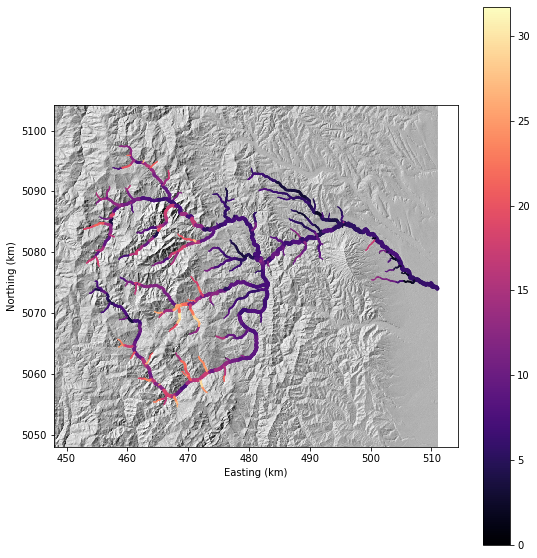

In [10]:
fig, ax = lsd.quickplot.get_basemap(mydem , figsize = (9,9), cmap = "gist_earth", hillshade = True, 
	alpha_hillshade = 1, cmin = None, cmax = None,
	hillshade_cmin = 0, hillshade_cmax = 1, colorbar = False, 
	fig = None, ax = None, colorbar_label = None, colorbar_ax = None, fontsize_ticks = 16, normalise_HS = True)
size_array = lsd.size_my_points(np.log10(mydem.df_ksn.drainage_area), 1,15)
cb = ax.scatter(mydem.df_ksn.x, mydem.df_ksn.y, lw=0, c= mydem.df_ksn.m_chi, cmap = "magma", zorder = 5, s=size_array)
plt.colorbar(cb)

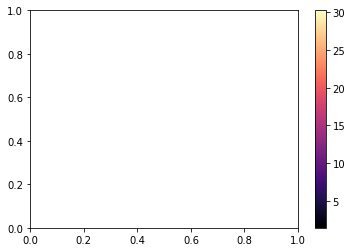